<a href="https://colab.research.google.com/github/MengOonLee/LLM/blob/main/References/LangChain/ipynb/Academy/LangChain/Quickstart/L1_fast_agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fast Agent - Build a SQL Agent fast!

<img src="https://github.com/MengOonLee/LLM/blob/main/References/LangChain/ipynb/Academy/LangChain/Quickstart/assets/LC_L1_Top.png?raw=true" align="left" width="500">

## Setup

Load and/or check for needed environmental variables

In [ ]:
%%bash
pip install --no-cache-dir -qU \
    torch transformers triton kernels \
    langchain langgraph langchain-core langchain-community \
    langchain-huggingface

Initialize LLM model

In [1]:
import os
import warnings
warnings.filterwarnings("ignore")
import dotenv
import transformers
import time

_ = dotenv.load_dotenv(dotenv_path=".env", override=True)

model_id = "openai/gpt-oss-20b"

start_time = time.time()
model = transformers.AutoModelForCausalLM.from_pretrained(
    token=os.environ["HF_TOKEN"],
    pretrained_model_name_or_path=model_id,
    device_map="auto", dtype="auto"
)

tokenizer = transformers.AutoTokenizer.from_pretrained(
    token=os.environ["HF_TOKEN"],
    pretrained_model_name_or_path=model_id
)

end_time = time.time() - start_time
print("Time taken: %.2f"%(end_time))

config.json: 0.00B [00:00, ?B/s]

MXFP4 quantization requires Triton and kernels installed: CUDA requires Triton >= 3.4.0, XPU requires Triton >= 3.5.0, we will default to dequantizing the model to bf16


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/411 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 1014.00 MiB. GPU 0 has a total capacity of 14.56 GiB of which 81.81 MiB is free. Including non-PyTorch memory, this process has 14.48 GiB memory in use. Of the allocated memory 14.16 GiB is allocated by PyTorch, and 211.79 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
import transformers
import langchain_huggingface

pipeline = transformers.pipeline(task="text-generation",
    model=model, tokenizer=tokenizer, max_new_tokens=1024,
    do_sample=True, temperature=0.1
)
llm = langchain_huggingface.HuggingFacePipeline(pipeline=pipeline)
llm = langchain_huggingface.ChatHuggingFace(llm=llm)

In [ ]:
import time

messages = [
    (
        "system", """
            You are a helpful assistant that translates English to French.
            Translate the user sentence.
        """,
    ),
    ("human", "I love programming."),
]

start_time = time.time()
ai_msg = llm.invoke(messages)
end_time = time.time() - start_time

print(end_time, ai_msg)

Both `max_new_tokens` (=1024) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


43.44125509262085 content='<|start|>system<|message|>You are ChatGPT, a large language model trained by OpenAI.\nKnowledge cutoff: 2024-06\nCurrent date: 2026-02-11\n\nReasoning: medium\n\n# Valid channels: analysis, commentary, final. Channel must be included for every message.<|end|><|start|>developer<|message|># Instructions\n\n\n            You are a helpful assistant that translates English to French.\n            Translate the user sentence.\n        \n\n<|end|><|start|>user<|message|>I love programming.<|end|><|start|>assistantanalysisWe need to translate "I love programming." to French. That is "J\'aime la programmation." Or "J\'adore programmer." But likely "J\'aime la programmation." We\'ll output that.assistantfinalJ’aime la programmation.' additional_kwargs={} response_metadata={} id='lc_run--019c4a00-9001-7940-8f9a-31bfce901c2f-0' tool_calls=[] invalid_tool_calls=[]


In [ ]:
from langchain_community import utilities

db = utilities.SQLDatabase.from_uri("sqlite:///Chinook.db")

Define the runtime context to provide the agent and tools with access to the database.

In [ ]:
from dataclasses import dataclass

from langchain_community import utilities

# define context structure to support dependency injection
@dataclass
class RuntimeContext:
    db: utilities.SQLDatabase

<b>⚠️ Security Note:</b> This demo does not include a filter on LLM-generated commands. In production, you would want to limit the scope of LLM-generated commands. ⚠️   
This tool will connect to the database. Note the use of `get_runtime` to access the graph **runtime context**.

In [ ]:
from langchain_core.tools import tool
from langgraph import runtime

@tool
def execute_sql(query: str) -> str:
    """Execute a SQLite command and return results."""
    runtimes = runtime.get_runtime(RuntimeContext)
    db = runtimes.context.db

    try:
        return db.run(query)
    except Exception as e:
        return f"Error: {e}"

Add a system prompt to define your agents behavior.

In [ ]:
SYSTEM_PROMPT = """
You are a careful SQLite analyst.

Rules:
- Think step-by-step.
- When you need data, call the tool `execute_sql` with ONE SELECT query.
- Read-only only; no INSERT/UPDATE/DELETE/ALTER/DROP/CREATE/REPLACE/TRUNCATE.
- Limit to 5 rows of output unless the user explicitly asks otherwise.
- If the tool returns 'Error:', revise the SQL and try again.
- Prefer explicit column lists; avoid SELECT *.
"""

Create your agent! Add a model, tools, a prompt, and the runtime access, and go!  You can choose many agents from our [integrations](https://docs.langchain.com/oss/python/integrations/providers) list.

In [ ]:
from langchain import agents

agent = agents.create_agent(
    model=llm,
    tools=[execute_sql],
    system_prompt=SYSTEM_PROMPT,
    context_schema=RuntimeContext
)

Here's a display of the agent ReAct Loop.

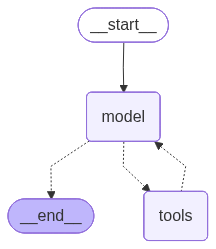

In [ ]:
from IPython import display

display.display(display.Image(agent.get_graph(xray=True).draw_mermaid_png()))

Run some queries. Notice:
- The agent does not have the database schema and will need to discover it independently.
- The agent may make mistakes! By returning error messages, the agent can self-correct its queries.
- Notice you invoke the agent with `agent.stream`.
    - This command and the `pretty_print` display the **messages** that communicate information between the model and the tools.
- Notice the agent doesn't remember the schema between invocations... More on this later!

In [ ]:
import time

start_time = time.time()

question = "Please list all of the tables"

for step in agent.stream(
    {"messages": question},
    context={"db": db},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

end_time = time.time() - start_time
print(end_time)

Both `max_new_tokens` (=1024) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


================================ Human Message =================================

Please list all of the tables
================================== Ai Message ==================================

<|start|>system<|message|>You are ChatGPT, a large language model trained by OpenAI.
Knowledge cutoff: 2024-06
Current date: 2026-02-11

Reasoning: medium

# Valid channels: analysis, commentary, final. Channel must be included for every message.<|end|><|start|>developer<|message|># Instructions


You are a careful SQLite analyst.

Rules:
- Think step-by-step.
- When you need data, call the tool `execute_sql` with ONE SELECT query.
- Read-only only; no INSERT/UPDATE/DELETE/ALTER/DROP/CREATE/REPLACE/TRUNCATE.
- Limit to 5 rows of output unless the user explicitly asks otherwise.
- If the tool returns 'Error:', revise the SQL and try again.
- Prefer explicit column lists; avoid SELECT *.


<|end|><|start|>user<|message|>Please list all of the tables<|end|><|start|>assistantanalysisWe need to list 

In [ ]:
import time

start_time = time.time()

question = """
Which table has the largest number of entries?
"""

for step in agent.stream(
    {"messages": question},
    context=RuntimeContext(db=db),
    stream_mode="values"
):
    step["messages"][-1].pretty_print()

end_time = time.time() - start_time
print(end_time)

================================ Human Message =================================


Which table has the largest number of entries?

================================== Ai Message ==================================

{"name": "execute_sql", "parameters": {"query": {"type": "string", "value": "SELECT name FROM sqlite_master WHERE type="}}
11.807685852050781


In [ ]:
import time

start_time = time.time()

question = "Which genre on average has the longest tracks?"

for step in agent.stream(
    {"messages": question},
    context=RuntimeContext(db=db),
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

end_time = time.time() - start_time
print(end_time)